<a href="https://colab.research.google.com/github/SDS-AAU/DSBA-2022/blob/master/notebooks/M3_workshop_sbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installing sentence transformer libary to work with SBERT
!pip install -qU transformers sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.4 MB/s eta 0:00:00


In [2]:
# standard stuff
import pandas as pd
import seaborn as sns

# Stuff we will need later
import os
import csv
import time

# Semantic Similarity 


## Introduction

Semantic search seeks to improve search accuracy by understanding the content of the search query. In contrast to traditional search engines, which only find documents based on lexical matches, semantic search can also find synonyms.

In fact, this type of search makes browsing more complete by understanding almost exactly what the user is trying to ask, instead of simply matching keywords to pages. The idea behind semantic search is to embed all entries in your corpus, which can be sentences, paragraphs, or documents, into a vector space.

At search time, the query is embedded into the same vector space and the closest embedding from your corpus is found. These entries should have a high semantic overlap with the query.

## Types of search: Symmetric vs. Asymmetric Semantic Search
A critical distinction for your setup is symmetric vs. asymmetric semantic search:

For **symmetric** semantic search your query and the entries in your corpus are of about the same length and have the same amount of content. An example would be searching for similar questions: Your query could for example be “How to learn Python online?” and you want to find an entry like “How to learn Python on the web?”. For symmetric tasks, you could potentially flip the query and the entries in your corpus.

For **asymmetric** semantic search, you usually have a short query (like a question or some keywords) and you want to find a longer paragraph answering the query. An example would be a query like “What is Python” and you wand to find the paragraph “Python is an interpreted, high-level and general-purpose programming language. Python’s design philosophy …”. For asymmetric tasks, flipping the query and the entries in your corpus usually does not make sense.

# Toy example

A simple example of a couple of sentences. Imagine our task is to calculate semantic similarity between them:

In [3]:
sentences = ["purple is the best city in the forest",
             "there is an art to getting your way and throwing bananas on to the street is not it",
             "it is not often you find soggy bananas on the street",
             "green should have smelled more tranquil but somehow it just tasted rotten",
             "joyce enjoyed eating pancakes with ketchup",
             "as the asteroid hurtled toward earth becky was upset her dentist appointment had been canceled",
             "to get your way you must not bombard the road with yellow fruit" ]

# Cross- vs Bi-Encoder

![](https://raw.githubusercontent.com/UKPLab/sentence-transformers/master/docs/img/Bi_vs_Cross-Encoder.png)

* **Bi-Encoders** produce for a given sentence a sentence embedding. We pass to a BERT independently the sentences A and B, which result in the sentence embeddings u and v. These sentence embedding can then be compared using cosine similarity:
* In contrast, for a **Cross-Encoder**, we pass both sentences simultaneously to the Transformer network. It produces than an output value between 0 and 1 indicating the similarity of the input sentence pair:

## BERT (Cross-Encoder)

Lets we'll take a look at how we can use transformer models (like BERT) to create sentence vectors for calculating similarity. Let's start by defining a few example sentences.

In [4]:
from transformers import AutoTokenizer, AutoModel
import torch

In [5]:
if not torch.cuda.is_available():
  print("Warning: No GPU detected. Processing will be slow. Please add a GPU to this notebook")

Initialize our HF transformer model and tokenizer - using a pretrained BERT model.

In [6]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')
model = AutoModel.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')

Tokenize all of our sentences.

In [7]:
tokens = tokenizer(sentences,
                   max_length=128,
                   truncation=True,
                   padding='max_length',
                   return_tensors='pt')

In [8]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [9]:
tokens['input_ids'][1]

tensor([  101,  2045,  2003,  2019,  2396,  2000,  2893,  2115,  2126,  1998,
         6886, 26191,  2006,  2000,  1996,  2395,  2003,  2025,  2009,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

Process our tokenized tensors through the model.

In [10]:
outputs = model(**tokens)
outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

Here we can see the final embedding layer, *last_hidden_state*.

In [11]:
embeddings = outputs.last_hidden_state
embeddings[0]

tensor([[-0.6239, -0.2058,  0.0411,  ...,  0.1490,  0.5681,  0.2381],
        [-0.3694, -0.1485,  0.3780,  ...,  0.4204,  0.5553,  0.1441],
        [-0.7221, -0.3813,  0.2031,  ...,  0.0761,  0.5162,  0.2813],
        ...,
        [-0.1894, -0.3711,  0.3034,  ...,  0.1536,  0.3265,  0.1376],
        [-0.2496, -0.5227,  0.2341,  ...,  0.3419,  0.3164,  0.0256],
        [-0.3311, -0.4430,  0.3492,  ...,  0.3655,  0.2910,  0.0728]],
       grad_fn=<SelectBackward0>)

In [12]:
embeddings[0].shape

torch.Size([128, 768])

Here we have our vectors of length *768*, but we see that these are not *sentence vectors* because we have a vector representation for each token in our sequence (128 in total). We need to perform a mean pooling operation to create the sentence vector.

The first thing we do is multiply each value in our `embeddings` tensor by its respective `attention_mask` value. The `attention_mask` contains **1s** where we have 'real tokens' (eg not padding tokens), and 0s elsewhere - so this operation allows us to ignore non-real tokens.

In [13]:
mask = tokens['attention_mask'].unsqueeze(-1).expand(embeddings.size()).float()
mask.shape

torch.Size([7, 128, 768])

In [14]:
mask[0]

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Now we have a masking array that has an equal shape to our output `embeddings` - we multiply those together to apply the masking operation on our outputs.

In [15]:
masked_embeddings = embeddings * mask
masked_embeddings[0]

tensor([[-0.6239, -0.2058,  0.0411,  ...,  0.1490,  0.5681,  0.2381],
        [-0.3694, -0.1485,  0.3780,  ...,  0.4204,  0.5553,  0.1441],
        [-0.7221, -0.3813,  0.2031,  ...,  0.0761,  0.5162,  0.2813],
        ...,
        [-0.0000, -0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0000, -0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0000, -0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       grad_fn=<SelectBackward0>)

Sum the remaining embeddings along axis 1 to get a total value in each of our 768 values.

In [16]:
summed = torch.sum(masked_embeddings, 1)
summed.shape

torch.Size([7, 768])

Next, we count the number of values that should be given attention in each position of the tensor (+1 for real tokens, +0 for non-real).

In [17]:
counted = torch.clamp(mask.sum(1), min=1e-9)
counted.shape

torch.Size([7, 768])

Finally, we get our mean-pooled values as the `summed` embeddings divided by the number of values that should be given attention, `counted`.

In [18]:
mean_pooled = summed / counted
mean_pooled.shape

torch.Size([7, 768])

Now we have our sentence vectors, we can calculate the cosine similarity between each.

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [20]:
# convert to numpy array from torch tensor
mean_pooled = mean_pooled.detach().numpy()

# calculate similarities (will store in array)
scores = np.zeros((mean_pooled.shape[0], mean_pooled.shape[0]))
for i in range(mean_pooled.shape[0]):
    scores[i, :] = cosine_similarity(
        [mean_pooled[i]],
        mean_pooled
    )[0]

In [21]:
scores

array([[ 1.00000024,  0.1869276 ,  0.28297698,  0.29628262,  0.27451017,
         0.10176268,  0.21696268],
       [ 0.1869276 ,  1.00000024,  0.72058773,  0.51428944,  0.11749661,
         0.19306953,  0.66182333],
       [ 0.28297698,  0.72058773,  1.00000012,  0.48864433,  0.23568964,
         0.1715714 ,  0.55993074],
       [ 0.29628262,  0.51428944,  0.48864433,  0.99999988,  0.26985496,
         0.37889439,  0.52388823],
       [ 0.27451015,  0.1174966 ,  0.23568964,  0.26985499,  0.99999994,
         0.23422143, -0.01599767],
       [ 0.1017627 ,  0.1930695 ,  0.17157137,  0.37889439,  0.23422143,
         1.00000024,  0.22319698],
       [ 0.21696268,  0.66182339,  0.55993074,  0.52388823, -0.01599768,
         0.22319701,  1.        ]])

We can visualize these scores:

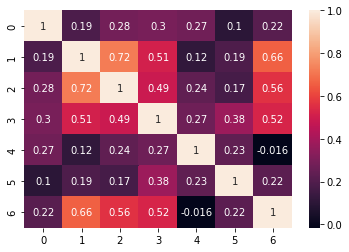

In [22]:
sns.heatmap(scores, annot=True)

## SBERT: sentence-transformers (bi-encoders)

The `sentence-transformers` library allows us to compress all of the above into just a few lines of code.

In [23]:
from sentence_transformers import SentenceTransformer, util
import torch

In [24]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

We encode the sentences (producing our mean-pooled sentence embeddings) like so:

In [25]:
sentence_embeddings = model.encode(sentences)

And calculate the cosine similarity just like before.

In [26]:
# calculate similarities (will store in array)
scores = np.zeros((sentence_embeddings.shape[0], sentence_embeddings.shape[0]))
for i in range(sentence_embeddings.shape[0]):
    scores[i, :] = cosine_similarity(
        [sentence_embeddings[i]],
        sentence_embeddings
    )[0]

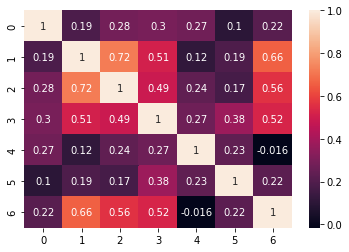

In [27]:
sns.heatmap(scores, annot=True)

We can also writ a small function to find the most similar sentences to each others

In [28]:
#Find the pairs with the highest cosine similarity scores
pairs = []
for i in range(len(scores)-1):
    for j in range(i+1, len(scores)):
        pairs.append({'index': [i, j], 'score': scores[i][j]})

In [29]:
#Sort scores in decreasing order
pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)

In [30]:
for pair in pairs[0:10]:
    i, j = pair['index']
    print("{} \t\t {} \t\t Score: {:.4f}".format(sentences[i], sentences[j], pair['score']))

there is an art to getting your way and throwing bananas on to the street is not it 		 it is not often you find soggy bananas on the street 		 Score: 0.7206
there is an art to getting your way and throwing bananas on to the street is not it 		 to get your way you must not bombard the road with yellow fruit 		 Score: 0.6618
it is not often you find soggy bananas on the street 		 to get your way you must not bombard the road with yellow fruit 		 Score: 0.5599
green should have smelled more tranquil but somehow it just tasted rotten 		 to get your way you must not bombard the road with yellow fruit 		 Score: 0.5239
there is an art to getting your way and throwing bananas on to the street is not it 		 green should have smelled more tranquil but somehow it just tasted rotten 		 Score: 0.5143
it is not often you find soggy bananas on the street 		 green should have smelled more tranquil but somehow it just tasted rotten 		 Score: 0.4886
green should have smelled more tranquil but somehow it 

Or do some semantic search:

In [31]:
# Query sentences:
queries = ['A man is eating pasta.', 'Someone in a gorilla costume is playing a set of drums.', 'A cheetah chases prey on across a field.']

In [32]:
# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = min(2, len(sentences))
for query in queries:
    query_embedding = model.encode(query)

    # We use cosine-similarity and torch.topk to find the highest 5 scores
    cos_scores = util.cos_sim(query_embedding, sentence_embeddings)[0]
    top_results = torch.topk(cos_scores, k=top_k)

    print("\n\n======================\n\n")
    print("Query:", query)
    print("\nTop  most similar sentences in corpus:")

    for score, idx in zip(top_results[0], top_results[1]):
        print(sentences[idx], "(Score: {:.4f})".format(score))





Query: A man is eating pasta.

Top  most similar sentences in corpus:
joyce enjoyed eating pancakes with ketchup (Score: 0.6399)
as the asteroid hurtled toward earth becky was upset her dentist appointment had been canceled (Score: 0.1599)




Query: Someone in a gorilla costume is playing a set of drums.

Top  most similar sentences in corpus:
there is an art to getting your way and throwing bananas on to the street is not it (Score: 0.2399)
it is not often you find soggy bananas on the street (Score: 0.1870)




Query: A cheetah chases prey on across a field.

Top  most similar sentences in corpus:
as the asteroid hurtled toward earth becky was upset her dentist appointment had been canceled (Score: 0.3025)
there is an art to getting your way and throwing bananas on to the street is not it (Score: 0.2145)


# Application: Semantic Search using SBERT on Quora Questions dataset

We use the Quora Duplicate Questions dataset, which contains about 500k questions (we only use about 100k):
https://www.quora.com/q/quoradata/First-Quora-Dataset-Release-Question-Pairs


As embeddings model, we use the SBERT model 'quora-distilbert-multilingual',
that it aligned for 100 languages. I.e., you can type in a question in various languages and it will
return the closest questions in the corpus (questions in the corpus are mainly in English).


In [33]:
model = SentenceTransformer('quora-distilbert-multilingual')

In [34]:
url = "http://qim.fs.quoracdn.net/quora_duplicate_questions.tsv"
dataset_path = "quora_duplicate_questions.tsv"
max_corpus_size = 100000

In [35]:
# Check if the dataset exists. If not, download and extract
# Download dataset if needed
if not os.path.exists(dataset_path):
    print("Download dataset")
    util.http_get(url, dataset_path)

Download dataset


  0%|          | 0.00/58.2M [00:00<?, ?B/s]

In [36]:
# Get all unique sentences from the file
corpus_sentences = set()
with open(dataset_path, encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_MINIMAL)
    for row in reader:
        corpus_sentences.add(row['question1'])
        if len(corpus_sentences) >= max_corpus_size:
            break

        corpus_sentences.add(row['question2'])
        if len(corpus_sentences) >= max_corpus_size:
            break

In [37]:
corpus_sentences = list(corpus_sentences)
print("Encode the corpus. This might take a while")
corpus_embeddings = model.encode(corpus_sentences, show_progress_bar=True, convert_to_tensor=True)

Encode the corpus. This might take a while


Batches:   0%|          | 0/3125 [00:00<?, ?it/s]

In [38]:
###############################
print("Corpus loaded with {} sentences / embeddings".format(len(corpus_sentences)))

Corpus loaded with 100000 sentences / embeddings


In [39]:
# Function that searches the corpus and prints the results
def search(inp_question):
    start_time = time.time()
    question_embedding = model.encode(inp_question, convert_to_tensor=True)
    hits = util.semantic_search(question_embedding, corpus_embeddings)
    end_time = time.time()
    hits = hits[0]  #Get the hits for the first query

    print("Input question:", inp_question)
    print("Results (after {:.3f} seconds):".format(end_time-start_time))
    for hit in hits[0:5]:
        print("\t{:.3f}\t{}".format(hit['score'], corpus_sentences[hit['corpus_id']]))

In [40]:
search("How do i write a really good data science project?")

Input question: How do i write a really good data science project?
Results (after 0.025 seconds):
	0.969	How do I build a data science team?
	0.958	What is the best way to get started with data science?
	0.951	How do I get started in data science?
	0.951	What is the best way to learn data science for a beginner?
	0.950	How do I get into a data science job?


In [41]:
#German: How can I learn Python online?
search("Wie kann ich online python lernen?")

Input question: Wie kann ich online python lernen?
Results (after 0.016 seconds):
	0.977	What's the best way to learn python on my own?
	0.972	What are some of the best ways to learn python?
	0.971	What are some tips for learning python?
	0.967	What is the best online resources to learn Python?
	0.966	How do I start learning python web programming from scratch to advanced?


In [42]:
#Chinese: How can I learn Python online?
search("如何在线学习python")

Input question: 如何在线学习python
Results (after 0.019 seconds):
	0.979	What's the best way to learn python on my own?
	0.977	How do I start learning python web programming from scratch to advanced?
	0.977	What are some of the best ways to learn python?
	0.977	What are some tips for learning python?
	0.960	How do I start learning machine learning and data science using python?


In [43]:
#Danish:What should I do at the weekend
search("hvad skal jeg laver om weekenden")

Input question: hvad skal jeg laver om weekenden
Results (after 0.017 seconds):
	0.972	What is the best way to spend the weekends ? (IT people)
	0.945	How should I spend my time over the summer?
	0.938	Assuming today is a weekday, is the upcoming weekend "this weekend" or "next weekend"?
	0.938	How do you spend your time in summer?
	0.934	What is the best way to spend a Sunday at home?


In [45]:
# French: How can I learn data science really fast?
search("comment puis-je apprendre la science des données très rapidement?")

Input question: comment puis-je apprendre la science des données très rapidement?
Results (after 0.037 seconds):
	0.986	How do I learn Data Science by “doing it”?
	0.979	What is the best way to learn data science for a beginner?
	0.968	What is the best way to get started with data science?
	0.964	How do I get started in data science?
	0.960	How can I learn Big Data on my own so that I can apply for a job in that area?


# Application: Patent search

* Check our application for [patent classification](https://github.com/AI-Growth-Lab/PatentSBERTa)
* ALso, see former W2V application in [this paper](https://doi.org/10.1016/j.techfore.2022.121559)

In [46]:
!pip install datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 19.7 MB/s eta 0:00:00


In [47]:
from datasets import load_dataset
import datasets

In [53]:
# Load our patent dataset sample
patent_dataset = datasets.load_dataset("AI-Growth-Lab/patents_claims_1.5m_traim_test", split="test[:10]")

Computing checksums:  50%|#####     | 1/2 [00:16<00:16, 16.48s/it]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/AI-Growth-Lab___csv/AI-Growth-Lab--patents_claims_1.5m_traim_test-4749f5a960fc1fe0/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


In [56]:
model = SentenceTransformer('AI-Growth-Lab/PatentSBERTa')

In [57]:
patent_dataset = pd.DataFrame(patent_dataset)

In [58]:
patent_dataset.text.head()

0    1. An apparatus for generating air pressure an...
1    1. A user-customizable audio-visual puzzle com...
2    1. A system comprising: circuitry configured t...
3    1. A semiconductor structure comprising: a sem...
4    1. A method comprising: capturing, by a camera...
Name: text, dtype: object

In [59]:
embeddings = model.encode(patent_dataset.text, convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

## Retrival

In [60]:
# Function that searches the corpus and prints the results
def semantic_search(inp_question):
    start_time = time.time()
    question_embedding = model.encode(inp_question, convert_to_tensor=True)
    hits = util.semantic_search(question_embedding, embeddings)
    end_time = time.time()
    hits = hits[0]  #Get the hits for the first query

    print("Input question:", inp_question)
    print("Results (after {:.3f} seconds):".format(end_time-start_time))
    for hit in hits[0:5]:
        print("\t{:.3f}\t{}".format(hit['score'], patent_dataset.text[hit['corpus_id']]))

In [61]:
# Query sentences:
queries = ['an apperatus that cleans dishes.']

In [62]:
semantic_search(queries)

Input question: ['an apperatus that cleans dishes.']
Results (after 0.053 seconds):
	0.393	1. A decorative system for the gables of a building comprising: a fascia cover including a first element of a pivot joint along a top edge and a first surface including an upper retainer tab and a lower retainer tab; a roof segment including a second element of the pivot joint pivotally attached to the first element of the pivot joint to form the pivot joint along a bottom surface of the roof segment; and an ornamental member including a top edge and a bottom edge, wherein the top edge of the ornamental member mates with the upper retainer tab of the fascia cover and the bottom edge of the ornamental member mates with the lower retainer tab of the fascia cover, wherein the first element of the pivot joint along the top edge of the fascia cover includes an approximately circular cylindrical cross-section.
	0.375	1. An apparatus for generating air pressure and high frequency air pulses to a garment